#Datasets

In [ ]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])
trainset_cifar = torchvision.datasets.CIFAR10(root='cifar10',train = True, download=True, transform = transform)
testset_cifar = torchvision.datasets.CIFAR10(root='cifar10', train = False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  #extends channels from 1 to 3 so it would match the icfar-10 images
    transforms.Resize((32, 32)),  # Resize to 32x32(cifar-10 size)
    transforms.ToTensor(),  #Tensor conversion
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
trainset_mnist = torchvision.datasets.MNIST(root='mnist', train=True, download=True, transform=transform)
testset_mnist = torchvision.datasets.MNIST(root='mnist', train = False, download=True, transform=transform)

In [ ]:
def get_mean(dataset1,dataset2):
  List = []
  for img1, img2 in zip(dataset1,dataset2):
    mean_image = (img1[0]+img2[0]) / 2
    List.append(mean_image)
  return List

In [ ]:
def convert_to_tensor(mean_images):
  mean_image=[]
  for i in mean_images:
   mean_image.append(torch.tensor(i))

  mean_images_stacked = torch.stack(mean_image)
  return mean_images_stacked


In [ ]:
mean_images = get_mean(trainset_mnist , trainset_cifar)

In [ ]:
mean_images

[tensor([[[-1.3276, -1.3903, -1.3629,  ..., -0.9393, -0.9629, -0.9786],
          [-1.4962, -1.5590, -1.4884,  ..., -1.0766, -1.0923, -1.0805],
          [-1.4609, -1.4962, -1.3668,  ..., -1.0962, -1.0884, -1.1315],
          ...,
          [-0.7433, -0.7707, -0.7825,  ..., -0.9315, -1.3393, -1.3511],
          [-0.8531, -0.8805, -0.8295,  ..., -0.8374, -1.1786, -1.2335],
          [-0.8648, -0.9001, -0.8570,  ..., -0.7119, -0.9668, -1.0766]],
 
         [[-1.2747, -1.3375, -1.3296,  ..., -1.0002, -1.0277, -1.0316],
          [-1.4394, -1.5179, -1.4865,  ..., -1.1728, -1.1924, -1.1767],
          [-1.4237, -1.4904, -1.4120,  ..., -1.1884, -1.1884, -1.2316],
          ...,
          [-0.8512, -0.9179, -0.8865,  ..., -0.9963, -1.3963, -1.3845],
          [-0.9728, -1.0355, -0.9532,  ..., -0.9375, -1.2747, -1.3100],
          [-0.9532, -1.0120, -0.9610,  ..., -0.7963, -1.0551, -1.1571]],
 
         [[-1.1552, -1.2258, -1.2336,  ..., -0.9787, -1.0022, -0.9983],
          [-1.3238, -1.4022,

In [ ]:
trainset = convert_to_tensor(mean_images)

<ipython-input-21-98df177fb92f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_image.append(torch.tensor(i))


In [ ]:
trainset = trainset.unsqueeze(0)

In [ ]:
test_mean_images = get_mean(testset_mnist,testset_cifar)

In [ ]:
testset = convert_to_tensor(test_mean_images)

<ipython-input-21-98df177fb92f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_image.append(torch.tensor(i))


In [ ]:
testset = testset.unsqueeze(0)

#Auto Encoder

In [ ]:
def CREATE_AUTO_ENCODER():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()


      self.enc = nn.Sequential(
        nn.Conv2d(3,16,4,padding=1,stride=2),
        nn.LeakyReLU(),
        nn.Conv2d(16,32,4,padding=1,stride=2),
        nn.LeakyReLU(),
        nn.Conv2d(32,64,4,padding=1,stride=2),
        nn.LeakyReLU()
        )

        #decoder layer
      self.dec = nn.Sequential(
        nn.ConvTranspose2d(64,32,4,padding=1,stride=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32,16,4,padding=1,stride=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16,3,4,padding=1,stride=2)
        )

    def forward(self,x):
      return self.dec( self.enc(x) )
  #model
  net = aenet()

  #loss func
  lossfun = nn.MSELoss()

  #optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer


In [ ]:
import numpy as np

def Training(trainset, testset, net, lossfun, optimizer, numepochs=50, batch_size=32):
    #use data loader to split data into batches
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)


    trainlosses = torch.zeros(numepochs)
    testlosses = torch.zeros(numepochs)


    for epochi in range(numepochs):
        net.train()
        batchlosses = []
        print("Epoch " + str(epochi+1) + " out of " + str(numepochs))


        for data in trainloader:
            X = data[0]
            yHat = net(X)  #Forward pass
            loss = lossfun(yHat, X)  #Compute the loss
            batchlosses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()  #Backward pass
            optimizer.step()  #Updating weights

        trainlosses[epochi] = np.mean(batchlosses)  #get the average training loss through the epoch
        print('Training loss: ', trainlosses[epochi])
        net.eval()  # Set the model to evaluation mode
        batchlosses = []
        with torch.no_grad():  #No gradient computation during evaluation
            for data in testloader:
                X = data[0]  # Get the input data
                yHat = net(X)  # Forward pass
                loss = lossfun(yHat, X)  # Compute the loss
                batchlosses.append(loss.item())  # Store the loss

        testlosses[epochi] = np.mean(batchlosses)  #get the average test loss through the epoch
        print('Testing Loss : ' , testlosses[epochi])

    return trainlosses, testlosses, net

In [ ]:
net,lossfun,optimizer = CREATE_AUTO_ENCODER()


In [ ]:
# test the model on a bit of data
trainlosses,testlosses,net = Training(trainset,testset,net,lossfun,optimizer)

Epoch 1 out of 50
Training loss:  tensor(1.0022)
Testing Loss :  tensor(0.9945)
Epoch 2 out of 50
Training loss:  tensor(0.9983)
Testing Loss :  tensor(0.9899)
Epoch 3 out of 50
Training loss:  tensor(0.9936)
Testing Loss :  tensor(0.9836)
Epoch 4 out of 50
Training loss:  tensor(0.9873)
Testing Loss :  tensor(0.9753)
Epoch 5 out of 50
Training loss:  tensor(0.9788)
Testing Loss :  tensor(0.9627)
Epoch 6 out of 50
Training loss:  tensor(0.9659)
Testing Loss :  tensor(0.9421)
Epoch 7 out of 50
Training loss:  tensor(0.9449)
Testing Loss :  tensor(0.9127)
Epoch 8 out of 50
Training loss:  tensor(0.9146)
Testing Loss :  tensor(0.8825)
Epoch 9 out of 50
Training loss:  tensor(0.8831)
Testing Loss :  tensor(0.8665)
Epoch 10 out of 50
Training loss:  tensor(0.8656)
Testing Loss :  tensor(0.8397)
Epoch 11 out of 50
Training loss:  tensor(0.8381)
Testing Loss :  tensor(0.8000)
Epoch 12 out of 50
Training loss:  tensor(0.7983)
Testing Loss :  tensor(0.7685)
Epoch 13 out of 50
Training loss:  te

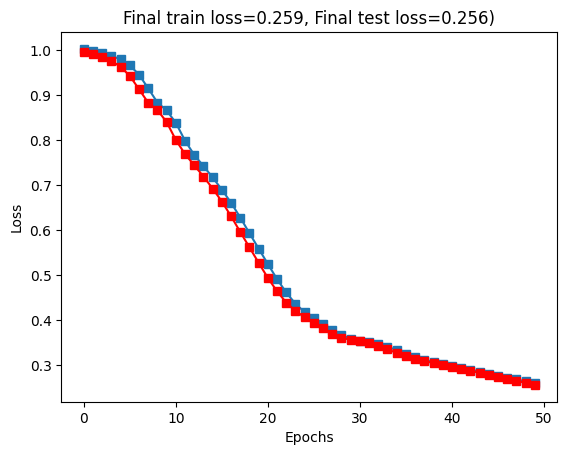

In [ ]:
#plot the losses

plt.plot(trainlosses,'s-',label='Train')
plt.plot(testlosses,'s-', color="red", label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Final train loss=%.3f, Final test loss=%.3f)' % (trainlosses[-1], testlosses[-1]))

plt.show()